# How to make a bivariate choropleth with GeoPandas and Matplotlib 🧙

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from adjustText import adjust_text
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
plt.style.use('science') # uncomment if you're using  https://github.com/garrettj403/SciencePlots
                         # map is going to be fancier 

Guess what? Yes, it is a short, *semi-automatic*tutorial on how to make a bivariate choropleth map with **GeoPandas** and **Matplotlib**!

My motivation is simple: I've tried to make such a map in R and QGIS but somehow found it difficult 😕. This notebook work in a *plug-in* mode: load your data and execute all cells below. Of course, there are "things" to tweak: colormap, map tiles, etcetera, but I'll point to these lines. Let's go!

We have only 5 main steps and 1 remark. Here is the outline:

1. Load the data
2. Bin the variables
3. Define colormap
4. Plot the map
5. Plot the legend

* Scaling & dealing with outliers.

## 1. Load the data

We have a simple data set with only 4 columns:
1. *District* - the name of a district in Amsterdam, 
2. *x* - the first variable of interest,
3. *y* - the second variable of interest,
4. *geometry* - district's geometry. The CRS of the geometry is EPSG:4326, but it can be any other. We're going to convert it to EPSG:3857 to use Contextily later on.

To build a bivariate choropleth, we will use 2 variables, x and y. Note that **we are going to use slightly prepared data**. Both of the variables have the same scale: from 0 to 1. Also, they do not have "outliers". If your variables have different scales or outliers, please refer to the end of this notebook. I list there some ways to handle it.

In [2]:
data = gpd.read_file('data.json')
data.head()
border = gpd.read_file('border.json')

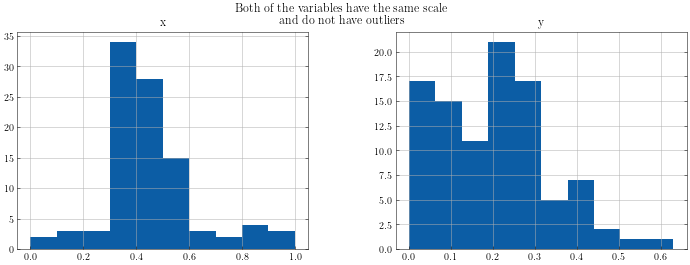

In [3]:
data[['x', 'y']].hist(figsize=(12,4));
plt.suptitle('Both of the variables have the same scale \n \
              and do not have outliers');

## 2. Binning

The first step is binning or simply putting variables into a set of intervals. There are many different ways how we can do it:

1. Use user-defined bins (*our approach*)
2. Calculate quantiles,
3. Use natural breaks and so on.

The "binning scheme" choice depends on the problem and the data. For example, you may want to discard extreme values on your map; then, quantiles can help. Perhaps, many of you are familiar with an excellent [mapclassify](https://github.com/pysal/mapclassify) package with many binning schemes implemented and explained. Check it out if you want to use other ways to do the binning.

**Importantly**, the number of bins made out of 2 variables must equal the number of categories you want to highlight in the choropleth. We will make 3 intervals for each of the variables to create 9 categories. You can also make 4 if you want or maybe even 25. Just make sure that the binning will give you these number of categories.

In [4]:
# Define the bins
bins = [0, 0.33, 0.66, 1]

# Bin the first variable - x
data['Var1_Class'] = pd.cut(data['x'], bins=bins, include_lowest=True)
data['Var1_Class'] = data['Var1_Class'].astype('str')

# Bin the second variable - y
data['Var2_Class'] = pd.cut(data['y'], bins=bins, include_lowest=True)
data['Var2_Class'] = data['Var2_Class'].astype('str')

# Code created x bins to 1, 2, 3
x_class_codes = np.arange(1, len(bins))
d = dict(zip(data['Var1_Class'].value_counts().sort_index().index, x_class_codes))
data['Var1_Class'] = data['Var1_Class'].replace(d)

# Code created y bins to A, B, C
y_class_codes = ['A', 'B', 'C']
d = dict(zip(data['Var2_Class'].value_counts().sort_index().index, y_class_codes))
data['Var2_Class'] = data['Var2_Class'].replace(d)

# Combine x and y codes to create Bi_Class
data['Bi_Class'] = data['Var1_Class'].astype('str') + data['Var2_Class']

In [5]:
print('Number of unique elements in Var1_Class =', len(data['Var1_Class'].unique()))
print('Number of unique elements in Var2_Class =', len(data['Var2_Class'].unique()))
print('Number of unique elements in Bi_Class =', len(data['Bi_Class'].unique()))

Number of unique elements in Var1_Class = 3
Number of unique elements in Var2_Class = 2
Number of unique elements in Bi_Class = 6


## 3. Define colormap

Now we need to:
1. Select the colormap,
2. Ensure that the resulting variable **Bi_Class** matches it. 

**Joshua Stevens** has a great tutorial [here](https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and we are going to use one of the templated that he proposed there.

We just copy-paste the colors as a list and define a colormap from it.

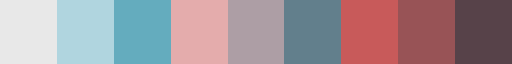

In [6]:
# All colors to create a complete legend
all_colors = ['#e8e8e8', '#b0d5df', '#64acbe', '#e4acac', '#ad9ea5', '#627f8c', '#c85a5a', '#985356', '#574249']
cmap = matplotlib.colors.ListedColormap(all_colors)
cmap

Since we have only 6 unique Bi_Class categories, we have to adjust the colormap to fit it. We have: 

'1A', '2A', '1B', '2B', '3A', '3B'

Thus, we have to "exclude" '1C', '2C', '3C'. We just going simply comment those colors and that is it.

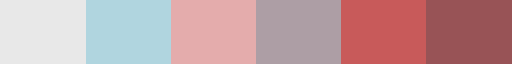

In [7]:
# Set of colors matching the elements of Bi_Class
# We have to exclude those that did not come up in the data
colors = ['#e8e8e8', # 1A
          '#b0d5df', # 1B
          # '#64acbe', # 1C
          '#e4acac', # 2A
          '#ad9ea5', # 2B
          # '#627f8c', # 2C
          '#c85a5a', # 3A
          '#985356'] # 3B
          # '#574249'] # 3C
            
cmap = matplotlib.colors.ListedColormap(colors)
cmap

## 4 & 5. Bivariate choropleth

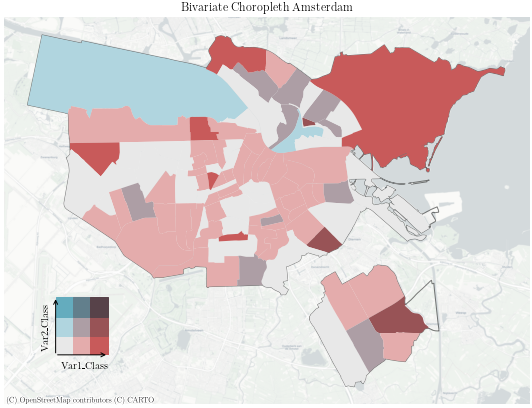

In [8]:
fig, ax = plt.subplots(figsize=(8,8))

# Step 1: Draw the map
border.to_crs('EPSG:3857').plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5) # city border
data.to_crs('EPSG:3857').plot(ax=ax, 
                              column='Bi_Class', # variable that is going to be used to color the map 
                              cmap=cmap, # newly defined bivariate cmap 
                              categorical=True, # bivariate choropleth has to be colored as categorical map 
                              legend=False) # we're going to draw the legend ourselves
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) # add the basemap

plt.tight_layout() # "tighten" two figures map and basemap
plt.axis('off') # we don't need axis with coordinates
ax.set_title('Bivariate Choropleth Amsterdam')

# Step 2: draw the legend

# We're drawing a 3x3 "box" as 3 columns
# The xmin and xmax arguments axvspan are defined to create equally sized small boxes

img2 = fig # refer to the main figure
ax2 = fig.add_axes([0.15, 0.25, 0.1, 0.1]) # add new axes to place the legend there
                                         # and specify its location 
alpha = 1 # alpha argument to make it more/less transperent

# Column 1
ax2.axvspan(xmin=0, xmax=0.33, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[0])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[1])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[2])

# Column 2
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[3])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[4])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[5])

# Column 3
ax2.axvspan(xmin=0.66, xmax=1, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[6])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[7])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[8])

# Step 3: annoate the legend
ax2.tick_params(axis='both', which='both', length=0) # remove ticks from the big box
ax2.axis('off'); # turn off its axis
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for x 
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for y 
ax2.text(s='Var1\_Class', x=0.1, y=-0.25) # annotate x axis
ax2.text(s='Var2\_Class', x=-0.25, y=0.1, rotation=90); # annotate y axis
plt.savefig('bivariate_choropleth.png', dpi=300)

## * Scaling & dealing with outliers

For bivariate choropleth, it is essential that the data:
* Does not have outliers
* Properly scaled

If the first is a **must**, the second can simplify the binning and plotting. 

Categories of the choropleth created on top of the data with outliers will likely be skewed, and the map's message can be misleading.

Regarding the second one, comparing two variables that differ from 0 to 1 is more straightforward than if both variables vary significantly.

There many ways to deal with outliers which again depend on your problem and the data. For example:
* Removing them,
* Using [z-score](https://en.wikipedia.org/wiki/Standard_score),
* [Winsorizing](https://en.wikipedia.org/wiki/Winsorizing).

Select approach that fits and apply to the data.

The type of scaling can be also critical. Read a great article [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) and get to know which method fits. 

Here is an example use of and winsorizing from scipy and MinMaxScaler from scikit-learn.

In [9]:
# Load the data
raw = gpd.read_file('raw.json')

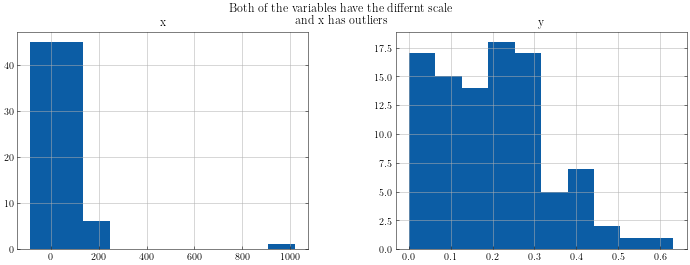

In [10]:
raw[['x', 'y']].hist(figsize=(12,4));
plt.suptitle('Both of the variables have the differnt scale \n \
              and x has outliers');

In [11]:
# Winsorize and scale the data
limits = [0.0, 0.025] # read more on limits here 
raw['x'] = winsorize(raw['x'], limits=limits)
raw['x'] = MinMaxScaler([0, 1]).fit_transform(raw['x'].values.reshape(-1,1))

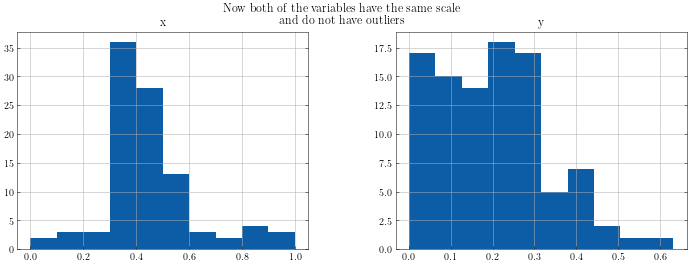

In [12]:
raw[['x', 'y']].hist(figsize=(12,4));
plt.suptitle('Now both of the variables have the same scale \n \
              and do not have outliers');

## References

* https://github.com/pysal/mapclassify
* https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
* https://en.wikipedia.org/wiki/Standard_score
* https://en.wikipedia.org/wiki/Winsorizing
* https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html